In [24]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

import mnist_loader

Carregando o MNIST dataset

In [97]:
# Loading MNIST dataset
training_data, validation_data, test_data = mnist_loader.load_data()

X_train, Y_train = np.concatenate((training_data[0], validation_data[0])), np.concatenate((training_data[1], validation_data[1]))
X_test, Y_test = test_data[0], test_data[1]

Definindo os parâmetros da MLP

In [105]:
NN_params = {
    'activation': 'logistic', # 'identity' / 'logistic' / 'tanh' / 'relu'
    'solver': 'sgd', # 'adam' / 'sgd' / 'lbfgs'
    'hidden_layers': (80, 70, 90),
    'learning_rate': 0.007,
    'batch_size': 100,
    'epochs': 100,
    'early_stopping': True,
    'tol': 0.0001,
    'n_iter_no_change': 3,
    'verbose': True
}

Criando e Treinando a MLP

In [106]:
mlp = MLPClassifier(
    activation=NN_params['activation'], batch_size=NN_params['batch_size'], early_stopping=NN_params['early_stopping'],
    hidden_layer_sizes=NN_params['hidden_layers'], learning_rate_init=NN_params['learning_rate'], max_iter=NN_params['epochs'],
    n_iter_no_change=NN_params['n_iter_no_change'], solver=NN_params['solver'], tol=NN_params['tol'],
    verbose=NN_params['verbose']
)

In [107]:
start = time.time()
mlp.fit(X_train, Y_train)
end = time.time()
total_time = end - start

Iteration 1, loss = 2.30570945
Validation score: 0.105833
Iteration 2, loss = 2.30378359
Validation score: 0.105833
Iteration 3, loss = 2.30185926
Validation score: 0.111500
Iteration 4, loss = 2.30025503
Validation score: 0.105833
Iteration 5, loss = 2.29531392
Validation score: 0.111500
Iteration 6, loss = 2.27403922
Validation score: 0.288000
Iteration 7, loss = 2.03797227
Validation score: 0.308500
Iteration 8, loss = 1.72792502
Validation score: 0.392333
Iteration 9, loss = 1.48483429
Validation score: 0.537167
Iteration 10, loss = 1.15697582
Validation score: 0.642000
Iteration 11, loss = 0.94816730
Validation score: 0.728500
Iteration 12, loss = 0.76847028
Validation score: 0.789000
Iteration 13, loss = 0.65479864
Validation score: 0.820167
Iteration 14, loss = 0.58704702
Validation score: 0.838500
Iteration 15, loss = 0.53840485
Validation score: 0.855667
Iteration 16, loss = 0.50010199
Validation score: 0.864833
Iteration 17, loss = 0.46771776
Validation score: 0.876500
Iterat

Verificando as predições da MLP sobre o subconjunto de testes

In [108]:
mlp_predictions = mlp.predict(X_test)

In [109]:
accuracy = accuracy_score(Y_test, mlp_predictions)
precision = precision_score(Y_test, mlp_predictions, average='micro')
recall = recall_score(Y_test, mlp_predictions, average='micro')


In [110]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}") # PRECISA AJUSTAR O PRECISION E O RECALL PARA MULTICLASS
print(f"Recall: {recall}")

Accuracy: 0.9669
Precision: 0.9669
Recall: 0.9669


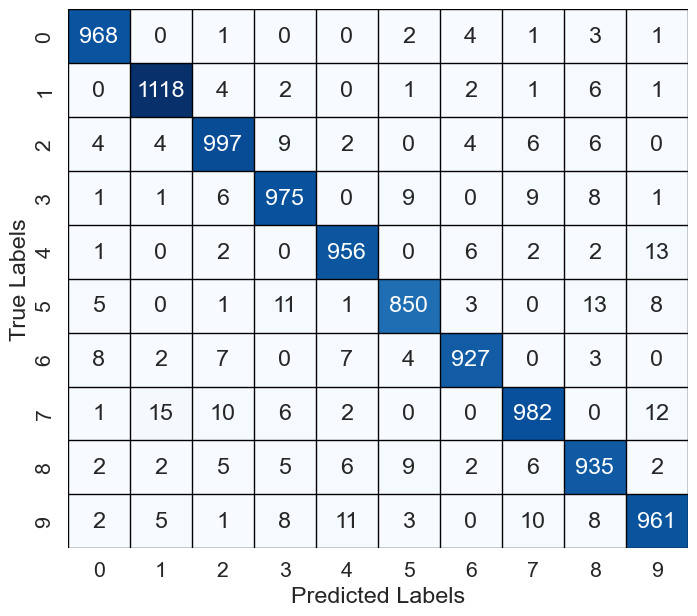

In [125]:
# Confusion Matrix
cm = confusion_matrix(Y_test, mlp_predictions)
plt.figure(figsize=(8, 7))

# Heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=range(10), yticklabels=range(10))

# Labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(11):
    plt.hlines(i, xmin=0, xmax=10, colors='black', linestyles='solid', linewidth=1)
    plt.vlines(i, ymin=0, ymax=10, colors='black', linestyles='solid', linewidth=1)

plt.show()